### CNN Classification Practice Code using Tensorflow

Batch Normalization 추가 버전

In [1]:
#모듈 임포트
import numpy as np
import tensorflow as tf

In [2]:
#데이터 로딩 (CIFAR10 dataset)
from tensorflow.keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
print('train shape: ', train_images.shape, train_labels.shape)
print('test shape: ', test_images.shape, test_labels.shape)

train shape:  (50000, 32, 32, 3) (50000, 1)
test shape:  (10000, 32, 32, 3) (10000, 1)


RGB 가 있으므로 train 데이터의 shape 는 4차원이 된다. 사실 Grayscale 데이터라도 채널 차원 1을 더해주어 4차원이 되게 데이터를 가공 해주는 것이 좋다.

In [4]:
#cifar10 데이터의 카테고리를 확인
NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

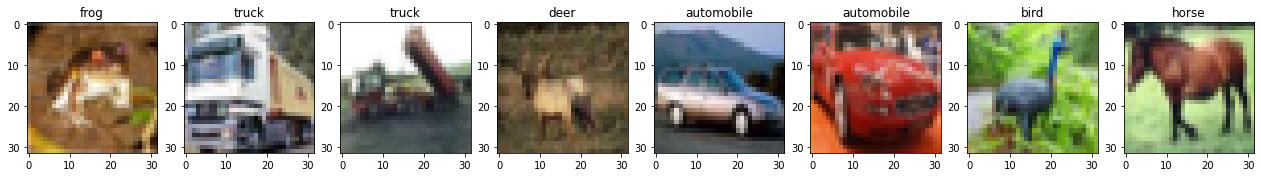

In [5]:
#데이터 시각화 
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

figure, axs = plt.subplots(figsize = (22,6), nrows = 1, ncols = 8)
for i in range(8):
  axs[i].imshow(train_images[i])
  label = train_labels[i].squeeze() #1차원으로 축소
  axs[i].set_title(NAMES[int(label)])

In [6]:
#데이터 전처리
#image array 가 0-255 사이의 값을 가지고 있어 pixel intensity 가 크다 => 0-1 값으로 바꿔줘야 한다

train_images, train_labels = np.array(train_images/255.0, dtype = np.float32), np.array(train_labels, dtype = np.float32) 
test_images, test_labels = np.array(test_images/255.0, dtype = np.float32), np.array(test_labels, dtype = np.float32) 

In [7]:
#위에서 확인 했을 때 label 데이터가 2차원이라 1차원으로 바꿔 가주는게 좋음
train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()

In [8]:
#one-hot encoding 진행
from tensorflow.keras.utils import to_categorical

train_oh_labels = to_categorical(train_labels)
test_oh_labels = to_categorical(test_labels)

In [9]:
#모델 생성! 필요 모듈 임포트
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

In [10]:
IMAGE_SIZE = 32

In [12]:
#filter 의 개수는 늘려가면서 행렬의 크기는 줄여가면서 convolution 을 실행
#BN 은 Activation 전에 적용 됨

def create_model():
    IMAGE_SIZE = 32
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    # cifar10의 클래스가 10개 이므로 마지막 classification의 Dense layer units갯수는 10
    x = Flatten(name='flatten')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(300, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.3)(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)

    model.summary()
    return model

In [13]:
#모델 생성 및 컴파일
model = create_model()
model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                             

In [14]:
#모델 학습 수행
#validation dataset 을 일정 부분 나누어 오버피팅이 일어나는지 확인
history = model.fit(x = train_images, y = train_oh_labels, batch_size = 64, epochs = 30, validation_split = 0.15)

Epoch 1/30
665/665 [==============================] - 29s 27ms/step - loss: 1.5606 - accuracy: 0.4409 - val_loss: 2.0983 - val_accuracy: 0.3561
Epoch 2/30
665/665 [==============================] - 17s 26ms/step - loss: 1.0905 - accuracy: 0.6123 - val_loss: 1.0246 - val_accuracy: 0.6133
Epoch 3/30
665/665 [==============================] - 17s 25ms/step - loss: 0.9009 - accuracy: 0.6857 - val_loss: 1.1056 - val_accuracy: 0.6312
Epoch 4/30
665/665 [==============================] - 17s 25ms/step - loss: 0.7904 - accuracy: 0.7247 - val_loss: 1.0707 - val_accuracy: 0.6464
Epoch 5/30
665/665 [==============================] - 17s 25ms/step - loss: 0.6969 - accuracy: 0.7586 - val_loss: 0.6951 - val_accuracy: 0.7541
Epoch 6/30
665/665 [==============================] - 17s 25ms/step - loss: 0.6438 - accuracy: 0.7788 - val_loss: 0.7976 - val_accuracy: 0.7281
Epoch 7/30
665/665 [==============================] - 17s 25ms/step - loss: 0.5872 - accuracy: 0.7983 - val_loss: 0.6619 - val_accuracy:

validation accuracy 가 train accuracy 에 비해 낮게 나옴

In [15]:
# 테스트 데이터로 성능 평가
model.evaluate(test_images, test_oh_labels)

313/313 [==============================] - 3s 9ms/step - loss: 0.6905 - accuracy: 0.8309


[0.6905079483985901, 0.8309000134468079]

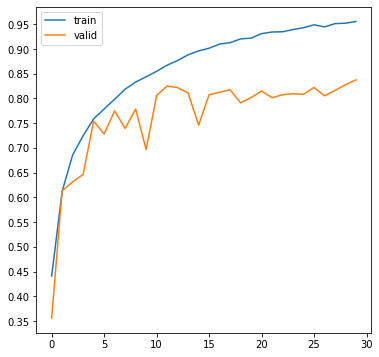

In [16]:
#훈련 데이터의 정확도와 검증 데이터의 정확도 시각화
plt.figure(figsize=(6, 6))
plt.yticks(np.arange(0, 1, 0.05))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()

In [17]:
#model.predict 사용해보기 
#4차원 이미지 배열을 통해 학습함에 주의!!

preds = model.predict(np.expand_dims(test_images[0],axis = 0))

In [18]:
print('예측 결과 shape:', preds.shape)
print('예측 결과:', preds)

예측 결과 shape: (1, 10)
예측 결과: [[2.3979990e-08 2.6528609e-11 4.7939331e-08 9.9999535e-01 2.2445656e-09
  4.5921493e-06 4.1784229e-09 3.8701277e-08 1.3323220e-08 1.9990993e-11]]


In [19]:
#예측 결과를 보고 어떤 클래스 인지 확인
predicted_class = np.argmax(preds, axis = 1) #argmax : 가장 큰 값의 인덱스 가져오기
print('예측 클래스 값: ', predicted_class)
print('예측 클래스 명: ', NAMES[predicted_class])

예측 클래스 값:  [3]
예측 클래스 명:  ['cat']


In [20]:
print(test_labels[0])

3.0


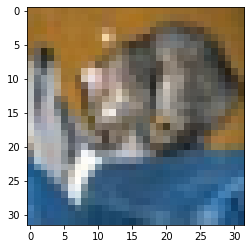

In [21]:
plt.imshow(test_images[0])

Batch Normalization 를 적용한 결과 validation accuracy 와 test accuracy 가 증가하였다.